# Preliminary Analysis
** In this section, prelminary analysis against the extrated dataset is going to take place including distribution analysis in different dimensions and contents analysis of the orginal data source** 

In [36]:
# import all necessary packages
from bs4 import BeautifulSoup
from collections import Counter
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import operator
import os
import pickle
import pprint
import re
import requests
import urllib, urllib2
from collections import defaultdict
from __future__ import division
from itertools import count
import pandas as pd
import random as rand
import datetime
import itertools
import Levenshtein
import difflib
# IPython specifics
%matplotlib inline

In [2]:
#load the data file
data_path =os.getcwd()+"\\merged_data.pkl"
print data_path

with open(data_path, 'rb') as handle:
    coms_df= pickle.load(handle)

D:\1st Semester Master\Social Graphs and interaction\Project\merged_data.pkl


In [3]:
print "There are in total {} companies loaded into the project".format(len(coms_df.keys()))
print coms_df['General Motors'].keys()

There are in total 56871 companies loaded into the project
['wb_api_url', 'links', 'founded', 'name_url_quoted', 'logo', 'subsid', 'location_city', 'wiki_url', 'wiki_name', 'location', 'homepage', 'is_company', 'wiki_raw', 'parent', 'num_employees', 'wiki_api_url', 'location_geopy', 'wb_api_search_url', 'defunct', 'name', 'countries', 'type', 'industry', 'key_people', 'location_country', 'products', 'all_links', 'location_gps', 'wiki_page_id']


### General Histogram Distribution Analysis in accordance with Found and Defunct year 

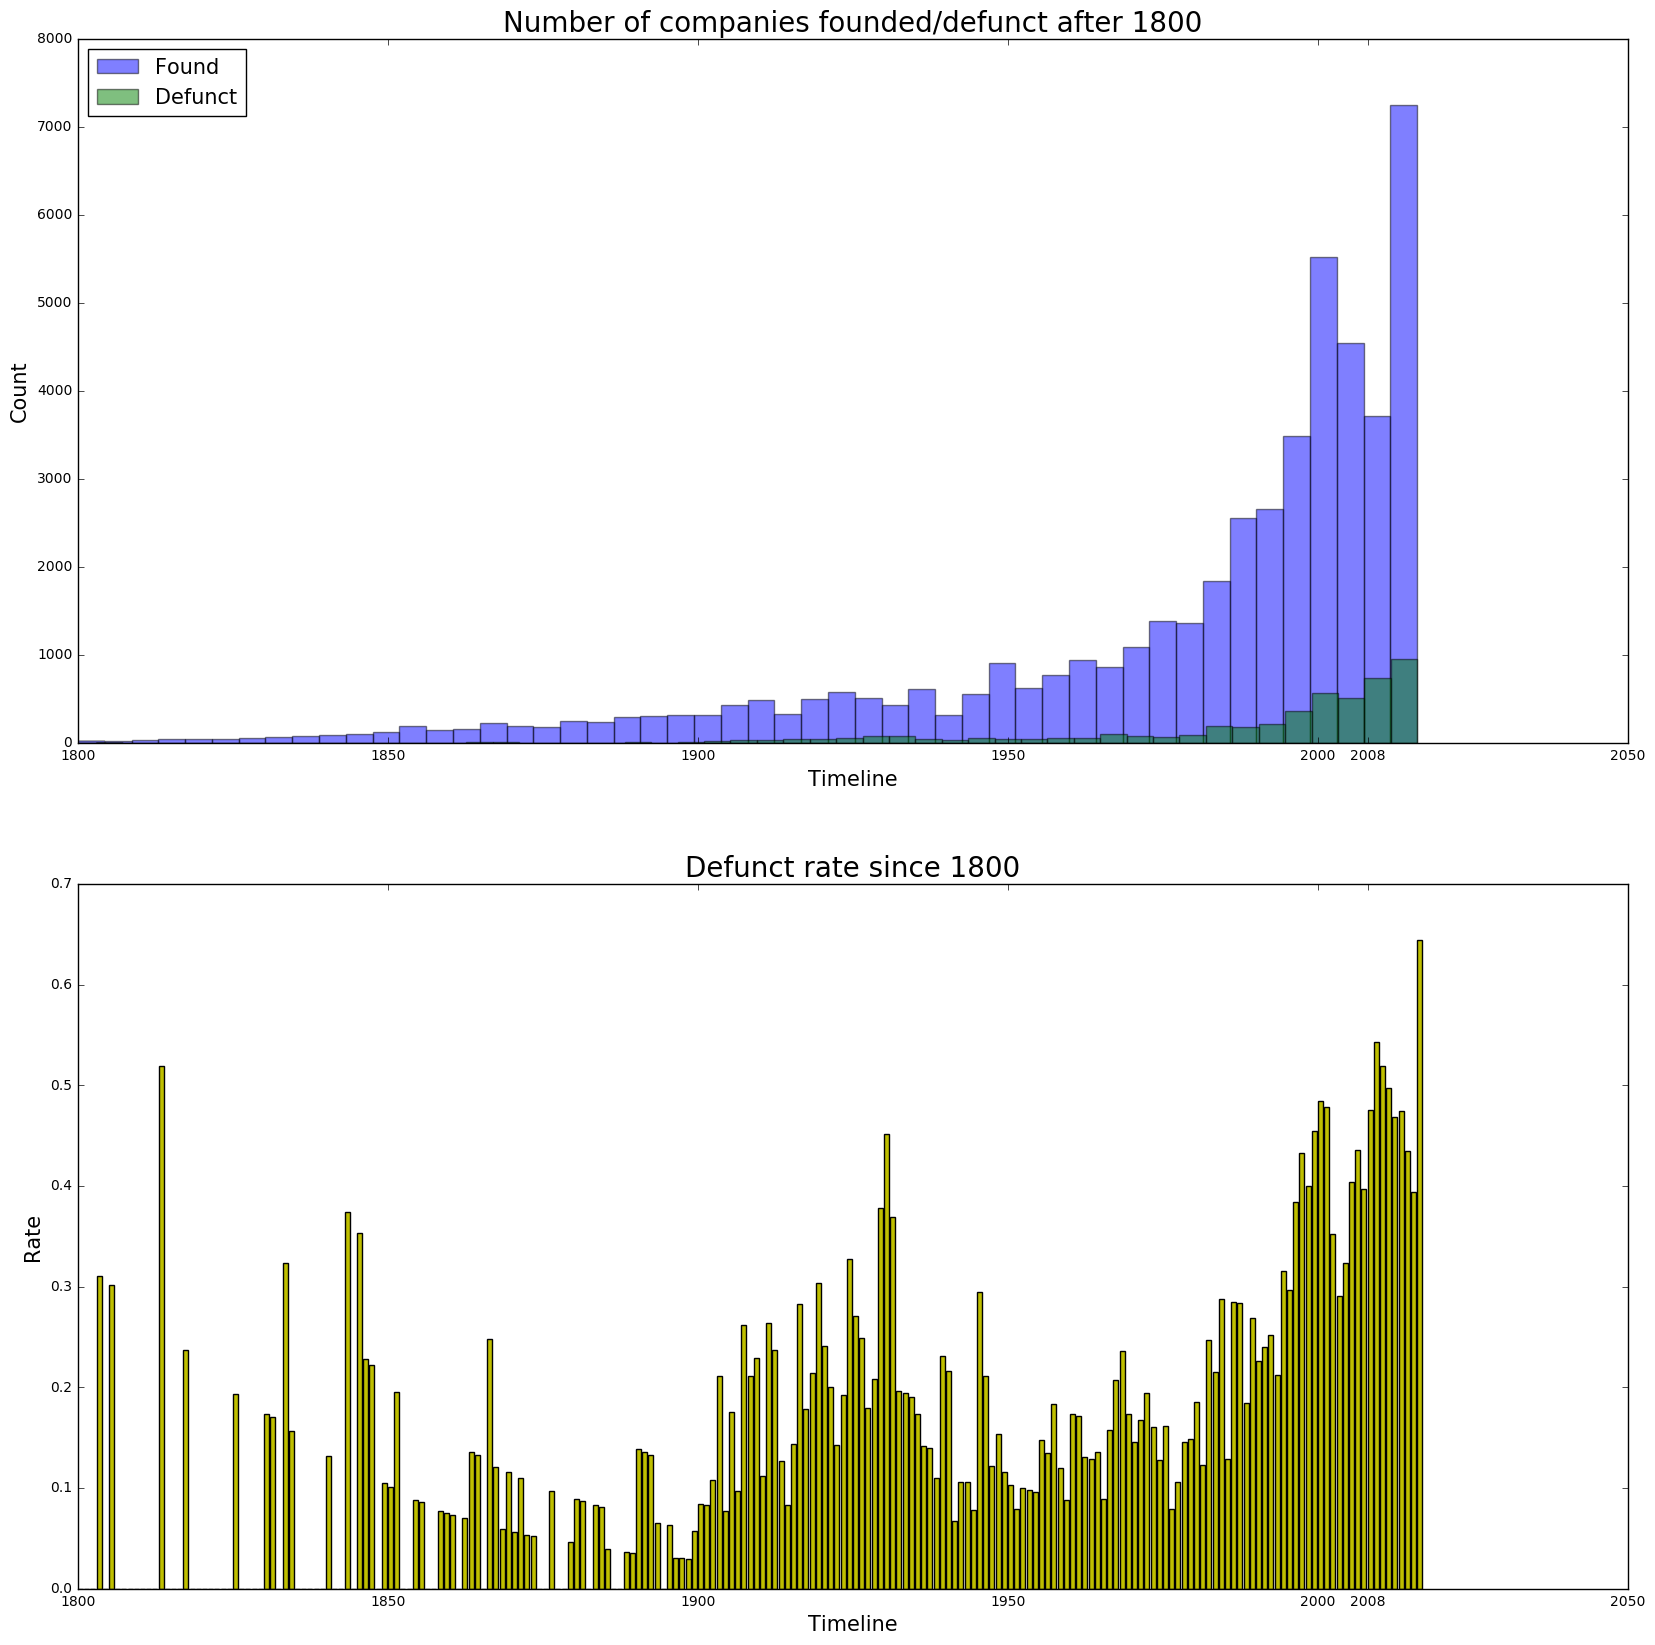

In [132]:
com_founded_years=list()
com_defounded_years=list()
acient=0
for com, com_detail in coms_df.iteritems():
    if com_detail['founded']: 
        found_year=int(com_detail['founded'].year)
        if found_year>=1800 and found_year<=int(datetime.date.today().year):
            com_founded_years.append(int(found_year))
        elif found_year<1800: 
            acient=acient+1 #count of com eariler than 1800
    if com_detail['defunct']:
        defound_year=int(com_detail['defunct'].year)
        if defound_year>=1800 and defound_year<=int(datetime.date.today().year):
            com_defounded_years.append(int(defound_year))     

            
#compute defunct rate
com_founded_dict= dict()
com_founded_cum=dict()
com_founded_count=Counter(com_founded_years)

for key in sorted(com_founded_count.iterkeys()):
    com_founded_dict[key]= com_founded_count[key]
    
    acient=acient+com_founded_count[key]
    com_founded_cum[key]= acient

defunt_cum=0
com_defounded_dict= dict()

com_defounded_count=Counter(com_defounded_years)
for key in sorted(com_defounded_count.iterkeys()):
    com_defounded_dict[key]= com_defounded_count[key]
    
    defunt_cum=defunt_cum+com_defounded_count[key]
    com_founded_cum[key]=com_founded_cum[key]-defunt_cum
#patching defunct dict
years_no_defunct=set(com_defounded_dict.keys()).symmetric_difference(com_founded_dict.keys())
for year_no_defunct in years_no_defunct:
    com_defounded_dict[year_no_defunct]=0
    
defunct_rates=list()
for cum, defunct in zip(com_founded_cum.values(),com_defounded_dict.values()):
    defunct_rates.append((defunct/cum)*100)


#plot histogram
fig = plt.figure(num=None, figsize=(20, 20), dpi=1200)
ax = fig.add_subplot(211)
count, bins, ignored = ax.hist(com_founded_years, bins=50,alpha=0.5, range=(min(com_founded_years), max(com_founded_years)),label="Found")
count, bins, ignored = ax.hist(com_defounded_years, bins=50,alpha=0.5, range=(min(com_defounded_years), max(com_defounded_years)),label="Defunct")

ax.legend(loc=2,fontsize=15)
ax.set_title("Number of companies founded/defunct after 1800",fontsize=20)
ax.set_xlabel('Timeline',fontsize=15)
ax.set_ylabel('Count',fontsize=15)
plt.xticks(list(plt.xticks()[0]) + [2008]) #add special tick for 2008, possible financial crisis influence

ax = fig.add_subplot(212)
ax.bar(com_founded_dict.keys(),defunct_rates,color='y')
ax.set_title("Defunct rate since 1800",fontsize=20)
ax.set_xlabel('Timeline',fontsize=15)
ax.set_ylabel('Rate',fontsize=15)


plt.xticks(list(plt.xticks()[0]) + [2008]) #add special tick for 2008, possible financial crisis influence
plt.show()

+ ** The histogram above shows the found and defunct of companies after 1800. The timeframe is set to 1800-2016 period (from early industrial revolution) as it is considered to be more morden society and the anaylsis is in result more connvincing. **

+ ** Generally, the amount of establishment increases gradually along the time. However in 2008, the number of founded company is significantly dropped. Possible reason would be partial side effect of the well-known Global Fiancial Crisis. **

+ ** The company defunct distribution has same tendency as company establishment. the amount generally increases along the time **

### Distribution of Company in accordance with Found/Defunct year in different industries

In [77]:
#get general industry
indust_years_dict=defaultdict(list)
for com, com_detail in coms_df.iteritems():
    if com_detail['industry'] and com_detail['industry'][0] is not None:
        com_indus=",".join([ind.lower() for ind in com_detail['industry']]).split(",")[0]
        if com_detail['founded']:
            indust_years_dict[com_indus].append(com_detail['founded'].year)

# similairity check using Levenshtein
threshold=0.6
for indus_1, indus_2 in itertools.combinations(indust_years_dict.keys(), 2):
    ratio=Levenshtein.ratio(indus_1,indus_2)
    if ratio>=threshold and indus_1 in indus_2:
        #print '%f\t%s\t\t could be \t\t%s' % (ratio, indus_1, indus_2)
        indust_years_dict[indus_1].extend(indust_years_dict[indus_2])
        del indust_years_dict[indus_2]

In [95]:
indust_len_dict=dict()
for indust, years in indust_years_dict.iteritems():
    indust_len_dict[indust]=len(years)
    
i=5
print "Top {} most registered (industry, quantity of company) {}".format(i, Counter(indust_len_dict).most_common(i))

Top 5 most registered (industry, quantity of company) [(u'retail', 1633), (u'financial', 1603), (u'communications', 1068), (u'automotive', 1032), (u'software', 988)]


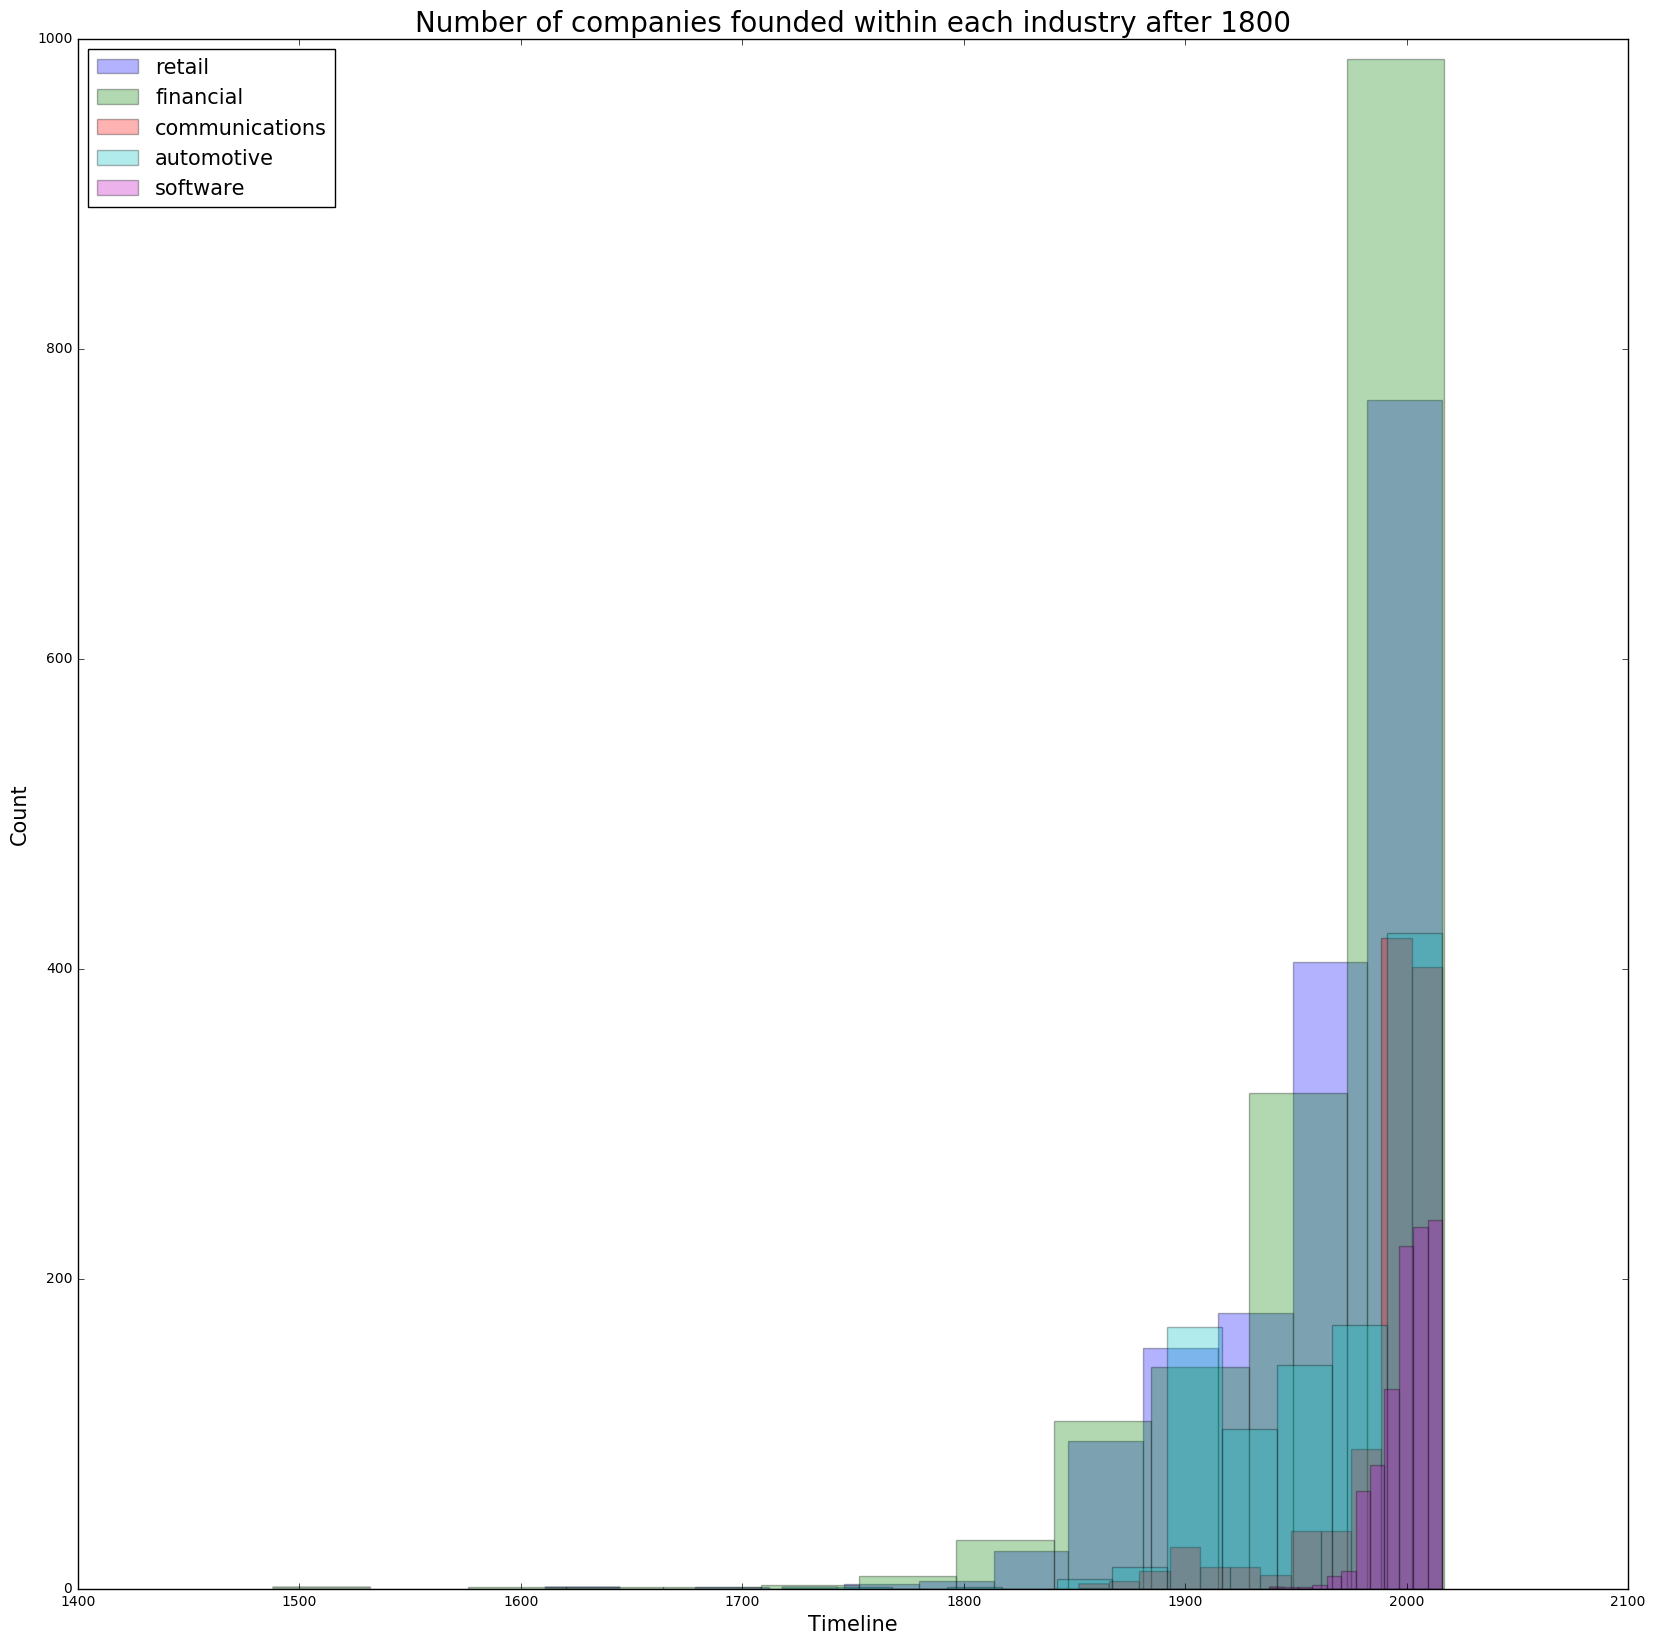

In [94]:
#plot histogram
fig = plt.figure(num=None, figsize=(20, 20), dpi=1200)
ax = fig.add_subplot(111)
for indust_tuple in Counter(indust_len_dict).most_common(i):
    indust_year_list=indust_years_dict[indust_tuple[0]]
    count, bins, ignored = ax.hist(indust_years_dict[indust_tuple[0]], bins=12,alpha=0.3,label=indust_tuple[0])


ax.legend(loc=2,fontsize=15)
ax.set_title("Number of companies founded within each industry after 1800",fontsize=20)
ax.set_xlabel('Timeline',fontsize=15)
ax.set_ylabel('Count',fontsize=15)

plt.show()

The plot has the distribution of established companies in several most common industries along the time. They respectively reflected the development of each industry and after some investigations, following observations have been made

+ ** Automobile industry remained silent and was suddenly boosted rapidly after 1900. Several historical events fecilitated the phenomenon. Prior to 1900, the automobile was really a novelty item, but in 1908, company such as Ford Motor Company created the Model T, which became the first car aggressively marketed to the average family. Commercialisation began **

+ ** Software industry starts to welcome a rapid increasin number of companies around 80s due to the extraoridinary development of computer. During the thrid industrial revolution (late 90s), more and more software or computer-related companies were founded. **
+ ** As same as software industry, the communication industry was also promptly developed after the invension of internet. Therefore, as the red bar in the plot shown, at the end of 20th centrey, a drasticall increment of the amount of founded companies within telecommunication industry has taken place **
+ ** The amount of company established in Retail and Finance industry generally comply to incremental tendency along the time. **

##  *** 1. Degree Distribution ***

  * ** 1.1 Plot the degree distribution of the companies in the network **
    + Plot the distribution in both linear & loglog fashion
    + Analyze whether preferentail attachment mechanism exist (or check whether the distribution very much like  Barabasi-Albert Model)
    +  Zipf's law applys? (20% top )

('Company network maximum degree:', 316, 'minimum degree:', 0)
Top 10 Companies by in-degree:
[(u'Reuters', 316), (u'Microsoft', 277), (u'IBM', 182), (u'Bloomberg L.P.', 176), (u'Los Angeles Times', 154), (u'Google', 148), (u'Sony', 132), (u'BBC', 132), (u'Apple Inc.', 129), (u'General Motors', 128)]


Top 10 Companies by out-degree:
[(u'HBO', 77), (u'Kohlberg Kravis Roberts', 75), ('AlpInvest Partners', 70), (u'Warner Bros.', 70), (u'Metro-Goldwyn-Mayer', 67), (u'Apollo Global Management', 67), (u'Samsung', 64), (u'Kroger', 61), (u'American Express', 60), (u'The Carlyle Group', 55)]


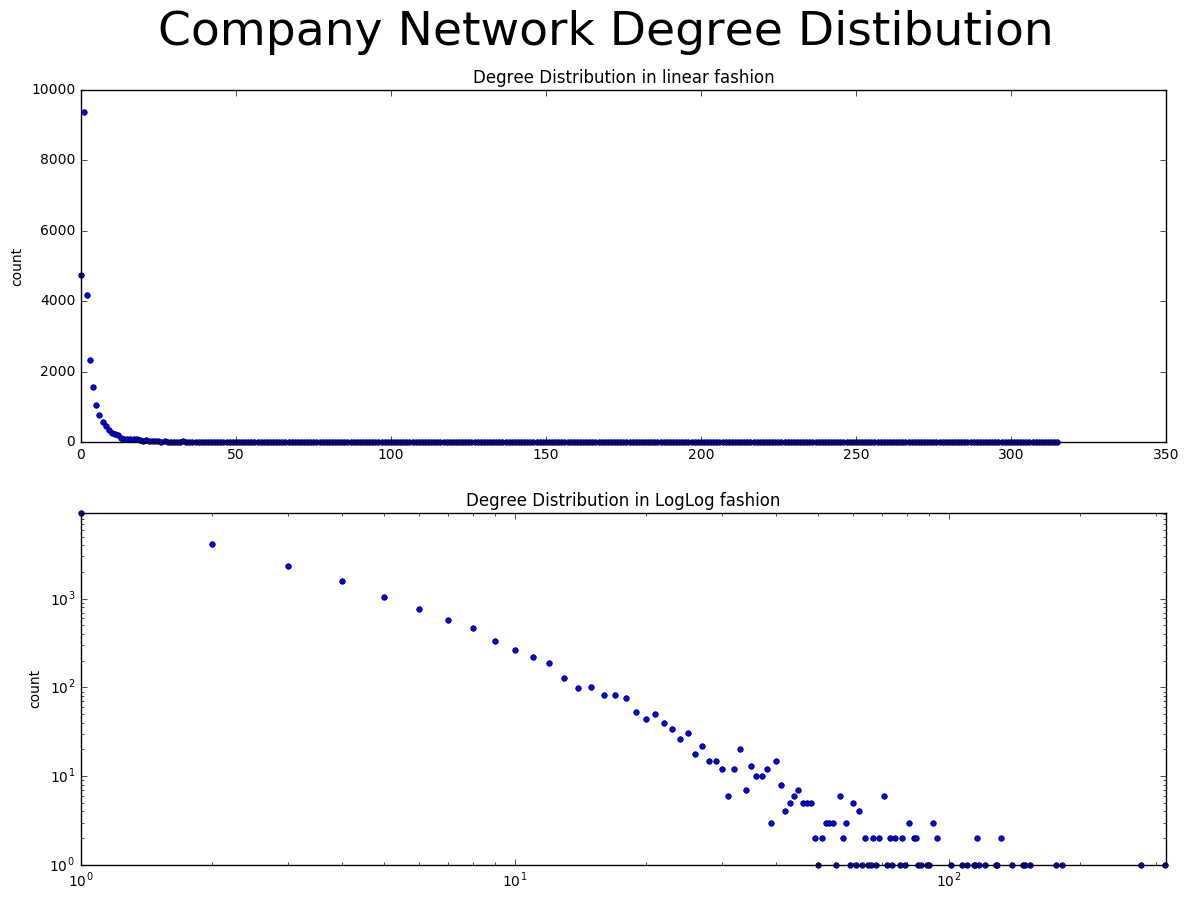

In [18]:
# get degree distribution

deg_seq_cn = sorted(nx.degree(com_graph).values(), reverse=True)
d_min_CN = min(deg_seq_cn)
d_max_CN = max(deg_seq_cn)
print ("Company network maximum degree:", d_max_CN, "minimum degree:", d_min_CN)

print 'Top 10 Companies by in-degree:\n', sorted(com_graph.in_degree_iter(), key=operator.itemgetter(1), reverse=True)[0:10]
print '\n\nTop 10 Companies by out-degree:\n', sorted(com_graph.out_degree_iter(), key=operator.itemgetter(1), reverse=True)[0:10]
# plot degree distribution
bins_CN = xrange(d_min_CN, d_max_CN+1) 
hist_CN, bin_edg_CN = np.histogram(deg_seq_cn, bins=bins_CN)

# plot histogram data (normal & loglog)
fig = plt.figure(num=None, figsize=(14, 10), dpi=80, facecolor='w', edgecolor='k')
fig.suptitle('Company Network Degree Distibution', fontsize=34)

plt.subplot('211')
plt.plot(bin_edg_CN[:-1], hist_CN, 'ro', color='blue', markersize=4, clip_on=False)
plt.ylabel("count")
plt.title("Degree Distribution in linear fashion")

plt.subplot('212')
plt.loglog(bin_edg_CN[:-1], hist_CN, 'ro', color='blue', markersize=4, clip_on=False)
plt.title("Degree Distribution in LogLog fashion")
plt.axis([min(bin_edg_CN), max(bin_edg_CN), min(hist_CN), max(hist_CN)])
plt.ylabel("count")
plt.show()

  * ** 1.2 Plot the in/out degree distribution of the companies in the network from directed graph **
* The correlation coefficient between in/out degree 

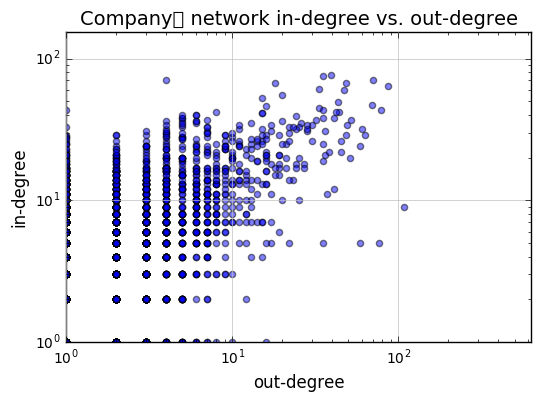

Correlation coefficient is: 0.159428841215


In [81]:
in_deg_val = com_graph.in_degree().values()
out_deg_val = com_graph.out_degree().values()

fig, ax = plt.subplots()

ax.set_title("Company network in-degree vs. out-degree", fontsize=14)
ax.set_xlabel("out-degree", fontsize=12)
ax.set_ylabel("in-degree", fontsize=12)

ax.grid(True, linestyle='-', color='0.75')
ax.set_xlim([1, max(in_deg_val) * 2])
ax.set_ylim([1, max(out_deg_val) * 2])
ax.set_xscale('log')
ax.set_yscale('log')

plt.scatter(in_deg_val, out_deg_val, alpha=0.5)

plt.show()

print ('Correlation coefficient is: {0}'.format(np.corrcoef(x=out_deg_val, y=in_deg_val)[0,1]))

## *** 2. Power-laws and the friendship paradox ***
  * **2.1 Does the neighbor companies of a company are popular than itself **

In [37]:
# pick a random company
i = rand.choice(com_graph.nodes())
iDegree = com_graph.degree(i)

In [38]:
#find all its neighbors
iNeighbors = com_graph.neighbors(i)
if len(iNeighbors)>0:
    fpDegree = sum(com_graph.degree(iNeighbors).values()) / float(len(iNeighbors))
print ("Random Company i:", i)
print ("Degree:", iDegree)
print ("Neighbors:", iNeighbors)
print ("Average degree of neighbors:", fpDegree)

('Random Company i:', 'Dapol')
('Degree:', 5)
('Neighbors:', [u'Airfix', u'BBC', u'Hornby Railways', u'Palitoy'])
('Average degree of neighbors:', 37.75)


+ in this case, friendshi parradox exist as Dapol's neighbor has higher degree...

  * **2.2 Assortativity of the company network **

In [97]:
print "Graph General assortativity:", nx.degree_pearson_correlation_coefficient(com_graph_undir)
print "Graph In-degree assortativity:", nx.degree_pearson_correlation_coefficient(com_graph,'in','in')
print "Graph Out-degree assortativity:", nx.degree_pearson_correlation_coefficient(com_graph,'out','out')

Graph General assortativity: -0.0156455430146
Graph In-degree assortativity: 0.00404256103891
Graph Out-degree assortativity: 0.0473633710718


+ In a Directed graph, in-assortativity and out-assortativity measure the tendencies of nodes to connect with other nodes that have similar in and out degrees as themselves, respectively. As it is shown. Company with similar out-degree has stronger corrrelation.

    
        
            

# Advanced Analysis

## *** 3. Company Centraility ***

  * ** 3.1 Generally, the 5 most central companies according to betweenness centrality **

In [42]:
node_dict = nx.betweenness_centrality(com_graph) 
#print Counter(node_dict).most_common(5) # use to print with betweenness_centrality

# just print the philosophers, from 1 (most central) to 5 (less central in top 5)
print sorted(node_dict, key=node_dict.get, reverse=True)[:5]

[u'DirecTV', u'Samsung', u'Bloomberg News', u'Nintendo', u'American Express']


  * ** 3.2 Generally, the 5 most central companies according to eigenvector centrality **

In [41]:
### eigenvector centrality
# in-edges
node_in_eigen = nx.eigenvector_centrality(com_graph)
# For out-edges eigenvector centrality first reverse the graph with G.reverse().
node_out_eigen = nx.eigenvector_centrality(com_graph.reverse())

print "5 most central companies according to in-edges eigenvector centrality:"
print sorted(node_in_eigen, key=node_in_eigen.get, reverse=True)[:5]
print "\nFor comparison:"
print "out-edges eigenvector centrality: ", sorted(node_out_eigen, key=node_out_eigen.get, reverse=True)[:5]


5 most central philosophers according to in-edges eigenvector centrality:
[u'Time Warner', u'Warner Bros.', u'Metro-Goldwyn-Mayer', u'Paramount Pictures', u'Los Angeles Times']

For comparison:
out-edges eigenvector centrality:  [u'HBO', u'Metro-Goldwyn-Mayer', u'Imagine Entertainment', u'Orion Pictures', u'DirecTV']


  * ** 3.3 Generally, the 5 most companies according to in/out degree centrality **

In [48]:
### degree centrality
# in-edges
node_in_degree = nx.degree_centrality(com_graph)
# out-edges
node_out_degree = nx.degree_centrality(com_graph.reverse())

print "in-edges degree centrality: ", sorted(node_in_degree, key=node_in_degree.get, reverse=True)[:5]
print "out-edges degree centrality: ", sorted(node_out_degree, key=node_out_degree.get, reverse=True)[:5]

in-edges degree centrality:  [u'Reuters', u'Microsoft', u'IBM', u'Bloomberg L.P.', u'Los Angeles Times']
out-edges degree centrality:  [u'Reuters', u'Microsoft', u'IBM', u'Bloomberg L.P.', u'Los Angeles Times']
